In [1]:
%gui tk
%matplotlib inline

import random
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
from skimage import transform
import scipy.ndimage as ndi
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#to increase accuracy, all images should have the same initial pixel/µm resolution
SLIDING_WINDOW_SIDE = 256
SLIDING_WINDOW_STEP = 128
TARGET_SCALE = 10 #pix per um
# IMAGE_HEIGHT_FINAL = 416
# IMAGE_WIDTH_FINAL = 416
# IMAGE_CHANNELS = 3
# BOX_WIDTH = 15 #px
# BOX_HEIGHT = 15 #px

In [3]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [4]:
# Choose directory with image and coordinate folders
data_dir = os.path.normpath(filedialog.askdirectory())

In [5]:
# Create a dataframe for images and coordinates
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
all_bounding_boxes = glob(os.path.join(data_dir, '*', '*.csv'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info, 'bounding_boxes_path': all_bounding_boxes})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

ValueError: arrays must all be same length

True

In [6]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
#     image = np.stack([image,image,image], 2)
    return image

In [7]:
# function to read scale from files
def read_scale(info_file):
    lines = [line for line in open(info_file)]
    regexp_scale = re.compile("(-?[0-9.]*) px per um")
    for line in lines:
        if regexp_scale.search(line):
            scale_px_per_um = regexp_scale.search(line).group(1)
    return float(scale_px_per_um)

In [8]:
# function to read bounding boxes from files
def read_bounding_boxes(bounding_box_file):
    boxes = np.genfromtxt(bounding_box_file, delimiter = ',')
    return boxes

In [9]:
# load scale and images from files
img_df['boxes'] = img_df['bounding_boxes_path'].map(read_bounding_boxes)
img_df['images'] = img_df['img_path'].map(load_image)
img_df['scale'] = img_df['info_path'].map(read_scale)

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: genfromtxt: Empty input file: "C:\Users\smirnovm\Documents\Data\Labeled_Spines_With_Bounding_Boxes\spine000480\spine_bounding_boxes000480.csv"
  This is separate from the ipykernel package so we can avoid doing imports until


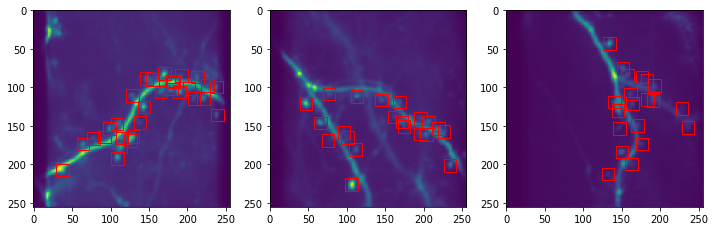

In [10]:
#Show a few sample split images with boxes
n_img = 3
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].loc[:n_img], range(n_img)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['boxes'].loc[ax_ind].shape) > 0:
        for pos in img_df['boxes'].loc[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(pos[:2],pos[2],pos[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)


In [11]:
# function to set box parameters as x_center, y_center, box_width, box_height, class
# class is 1 for all boxes
def translate_boxes_to_yolo(boxes):
    yolo_boxes = []
    boxes = boxes.reshape(-1,4)
    for box in boxes:
        if box.size > 0:
            box = np.append(box,1)
            box[0] = box[0] + box[2]/2
            box[1] = box[1] + box[3]/2
        else:
            box.reshape(-1,5)
        yolo_boxes.append(box)
    return np.array(yolo_boxes)

In [12]:
# translate boxes to yolo format
img_df['boxes_yolo'] = img_df['boxes'].map(translate_boxes_to_yolo)

In [13]:
# function to resize images and boxes to default scale. Images smaller than sliding window size will not be resized.
def resize_to_scale(image, boxes, scale):
    resize_scale = TARGET_SCALE/scale
    new_shape = np.array(image.shape)
    new_shape[:2] = np.array(new_shape[:2]*resize_scale, dtype = np.int)
    boxes_rescaled = boxes * resize_scale
    image_rescaled = transform.resize(image, new_shape)
    return image_rescaled,boxes_rescaled

def rescale_row(row):
    image, boxes = resize_to_scale(row['images'],row['boxes_yolo'],row['scale'])
    row['images_rescaled'] = image
    row['boxes_rescaled'] = boxes
    return row

In [14]:
# rescale all images
img_df = img_df.apply(rescale_row, axis = 1)

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
# function to convert all images to floats and make sure they are in a range of 0 and 1
def convert_images_to_float(image):
    image_float = image.astype(np.float16) / np.max(image)
    return image_float

In [16]:
img_df['images_float'] = img_df['images_rescaled'].map(convert_images_to_float)

In [34]:
# create images of set size using sliding window
def sliding_window(image, boxes, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            if boxes.size > 0:
                boxes = boxes.reshape(-1,5)
                boxes_in_window_ind = (boxes[:,0] > x) & (boxes[:,0] < x + SLIDING_WINDOW_SIDE) & (boxes[:,1] > y) & (boxes[:,1] < y + SLIDING_WINDOW_SIDE)
                boxes_in_window = boxes[boxes_in_window_ind,]
                boxes_in_window[:,0] = boxes_in_window[:,0] - x
                boxes_in_window[:,1] = boxes_in_window[:,1] - y
            else: boxes_in_window = boxes
            img_window = image[y:y + windowSize[1], x:x + windowSize[0]]
#             pad_rows = (0, windowSize[1] - img_window.shape[0])
#             pad_cols = (0, windowSize[0] - img_window.shape[1])
#             img_window = np.pad(img_window,(pad_rows,pad_cols),'constant')
            yield (x, y, img_window, boxes_in_window)

In [18]:
#directory to save data
save_dir = os.path.normpath(filedialog.askdirectory())

In [35]:
# individually save all sliding window images and their corresponding boxes to individual folders. 
# These will be loaded and preprocessed with the yolo program
file_list = []
for index, row in img_df.iterrows():
    if (index%500 == 0) & (index > 1):
        print('Splitting image #{}/{}'.format(index,len(img_df)))
    # make directory where all image windows will go
    image_dir = os.path.join(save_dir,'image{}'.format(index))
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    for (x, y, window, boxes_in_window) in sliding_window(row['images_float'], row['boxes_rescaled'], stepSize=SLIDING_WINDOW_STEP, windowSize=(SLIDING_WINDOW_SIDE, SLIDING_WINDOW_SIDE)):
        window_file_path = os.path.join(image_dir,'window_x_{}_y_{}_data.npz'.format(x,y))
        file_list.append(window_file_path)
        np.savez(window_file_path,image = window, boxes = boxes_in_window)

np.savez(os.path.join(save_dir,'file_list.npz'),file_list = np.array(file_list))
print('Saving done yay')

Splitting image #500/2574
Splitting image #1000/2574
Splitting image #1500/2574
Splitting image #2000/2574
Splitting image #2500/2574
Saving done yay
